In [2]:
#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
#########################
######### DICTIONARIES DEFINITION 
#########################

# Coordinates for small regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg = {
    'lab': {
        'lon' : (-55, -51),
        'lat' : (56, 59),
        'name' : 'Labrador Sea'
    },
    'irm': {
        'lon' : (-39, -35),
        'lat' : (58, 61),
        'name' : 'Irminger Sea'
    },
    'gul': {
        'lon' : (-57, -53),
        'lat' : (34, 38),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-20, -16),
        'lat' : (50, 53),
        'name' : 'North East Sea'
    }
}



# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'noa':{
        'lon' : (-90, 50),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [4]:
def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


## Function to crop the dataset

def Crops(d_set, lon1=None, lon2=None, lat1=None, lat2=None, reg_name=None, dic=None):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by a variable dictionary.
        
        Parameters:
        ------------
          
        d_set : DataArray
            Dataset to be cropped
        
        lon : float
            Tuple for the longitude limits of the region selected.
        
        lat : float
            Tuple for the latitude limits of the region selected.
      
        reg_name : string
            Key value that identifies the region to obtain
        
        dic : dictionary
            Is the dictionary from which we extract the coordinates
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    
    if dic :
        lon1, lon2 = dic[reg_name]['lon']
        lat1, lat2 = dic[reg_name]['lat']
        name_fig = dic[reg_name]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))

    return(new_ds)


def Histogram(data_set, n_bins, xlims=None, ylims=None, i=None, ax=None, alpha=0.85, 
              htype='bar', label=None, normed=None, lw=None):
    """
        Histogram is a function that helps to make a semi-log histogram plot
        of a dataset. The 'y' axis is logaritmic, and the 'x' axis is linear.
        The function accepts a dataset with any kind of values and it filters the
        nan values.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        n_bins : integer
            Number of bins for the histogram.
            
        xlims : tuple, float
            The limits for the x axis
        
        ylims : tuple, float
            The limits for the y axis
        
        i : integer
            Is the time step we are working on. if None, it returns the
            complete array's histogram
            
        ax : axes.Axes object or array of Axes objects
            axes of the n-th sub plot
        
        Output:
        -------
        Plot, Fig.
    """
    ## Creation of an array to save all values for the histogram
    ### This could be done in a faster way!!
    
    a = []
    
    if i == None:
        for j in range(len(data_set[:])):
            a = np.append(a, data_set[j])
    else:
        for j in range(len(data_set[i])):
            a = np.append(a, data_set[i, j])

    ##Taking away the nan values
    a2 = No_nan(a)
    ran = (xlims)
        
    if not ax:
        ax = plt.gca()
    
    N, bins, patches = ax.hist(a2, n_bins, range=ran, histtype=htype, 
                               label=label, alpha=alpha, normed=normed, linewidth=lw)
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_xlabel('MLD (m)', fontsize=10)
    ax.set_ylabel('# of occuped grid points', fontsize=10)
    ax.grid(True)
    
    return(N, bins, patches)
    
    
    
def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [5]:
def Year_sel(data_set, yr):
    """
        Year_sel slects an specific year from a dataset.  
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        yr : int
            Number of the year we want 
        
        Output:
        ------------
        y : dataArray
            DataArray containing only the data corresponding to yr
            
    """
    cond = data_set.time.dt.year.isin([yr])
    y = data_set.sel(time=cond)
    
    return(y)

def Point_sel(data_set, lon, lat, isel=True):
    """
        Point_sel selects a point given the latitude and longitude, or the 
        index of the array. The default function is using isel. If sel() wants
        to be used, the nearest method is used to select the point.
        
        
        Parameters:
        ------------
            
        data_set : DataArray
            Array from we extract the year.
        
        lon : float
            Coordinate for longitude.
        
        lat : float
            Coordinate for latitude.
        
        Output:
        ------------
        p : dataArray
            DataArray containing only the data corresponding to (lon, lat)
            
    """
    if isel:
        p = data_set.isel(longitude=lon, latitude=lat)
    else:
        p = data_set.sel(longitude=lon, latitude=lat, method='nearest')
    
    return(p)
  
    


In [6]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening datasets
dir_1 = '../../data_ARMOR/'
fl_n1 = 'ARMOR_*.nc'

c_armor = xr.open_mfdataset(dir_1 + fl_n1)
c_armor = Masking(c_armor, c_armor.to[0,25])


In [7]:
def Season(month):
    return (month >= 1) & (month <= 3)

# Let's see the Gulf Stream: Mean and Standard deviation

In [8]:
#Crops(d_set, lon1=None, lon2=None, lat1=None, lat2=None, reg_name=None, dic=None):
gulf = Crops(c_armor, lon1=None, lon2=None, lat1=None, lat2=None, reg_name='gul', dic=reg_ext)

del c_armor

In [9]:
winter_data = gulf.sel(time=Season(gulf['time.month']))

winter_data.mlotst

<xarray.DataArray 'mlotst' (time: 180, latitude: 60, longitude: 120)>
dask.array<shape=(180, 60, 120), dtype=float32, chunksize=(13, 60, 120)>
Coordinates:
  * latitude   (latitude) float32 30.125 30.375 30.625 ... 44.375 44.625 44.875
  * longitude  (longitude) float32 -74.875 -74.625 -74.375 ... -45.375 -45.125
  * time       (time) datetime64[ns] 2005-01-05 2005-01-12 ... 2018-03-28
    mask       (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_theta
    long_name:      Mixed layer depth from density threshold equivalent to a ...
    units:          m
    unit_long:      meter

In [10]:
JFM_mn = winter_data.mlotst.mean(dim='time')
JFM_st = winter_data.mlotst.std(dim='time')

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<IPython.core.display.Javascript object>


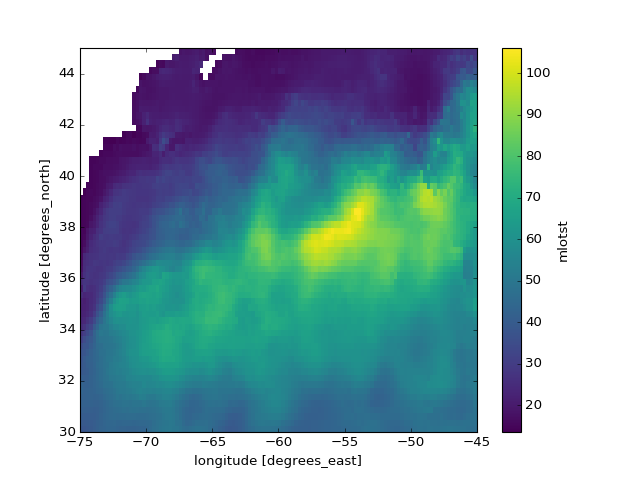

In [11]:
%matplotlib notebook

plt.close()
gulf.mlotst.mean(dim='time').plot(robust=False)

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<IPython.core.display.Javascript object>


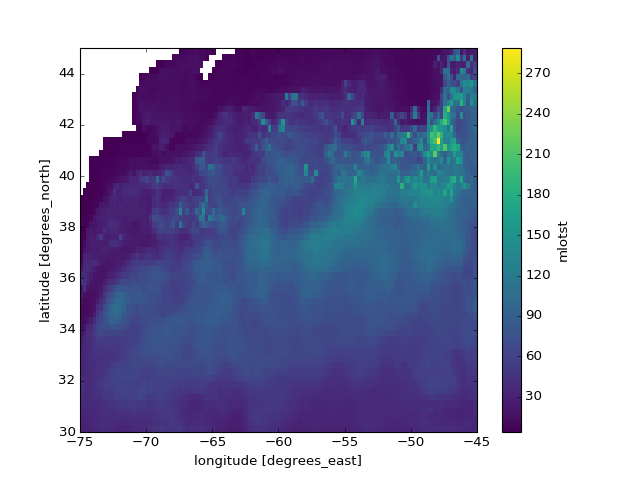

In [12]:
%matplotlib notebook

plt.close()
gulf.mlotst.std(dim='time').plot(robust=False)

<IPython.core.display.Javascript object>


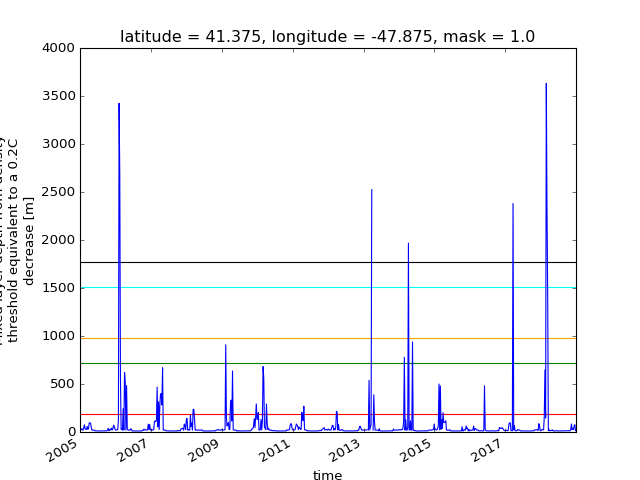

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n


In [13]:
c0 = JFM_mn + 1. * JFM_st
c1 = JFM_mn + 1.5 * JFM_st
c2 = JFM_mn + 2.5 * JFM_st
c3 = JFM_mn + 3. * JFM_st



plt.close()
gulf.mlotst.sel(longitude=-47.875, latitude=41.375).plot()

plt.hlines(JFM_mn.sel(longitude=-47.875, latitude=41.375), '01-01-2005', '31-12-2018', color='red')
plt.hlines(c0.sel(longitude=-47.875, latitude=41.375), '01-01-2005', '31-12-2018', color='green')
plt.hlines(c1.sel(longitude=-47.875, latitude=41.375), '01-01-2005', '31-12-2018', color='orange')
plt.hlines(c2.sel(longitude=-47.875, latitude=41.375), '01-01-2005', '31-12-2018', color='cyan')
plt.hlines(c3.sel(longitude=-47.875, latitude=41.375), '01-01-2005', '31-12-2018')

## Filtering:

### Using  MLD >=  mean +2.5 $\sigma$

Lets say that I want to get rid of the values that are MLD >= 2.5 $\sigma$

In [22]:
#c1 = JFM_mn + 1.5 * JFM_st
c2 = JFM_mn + 2.5 * JFM_st

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


<IPython.core.display.Javascript object>


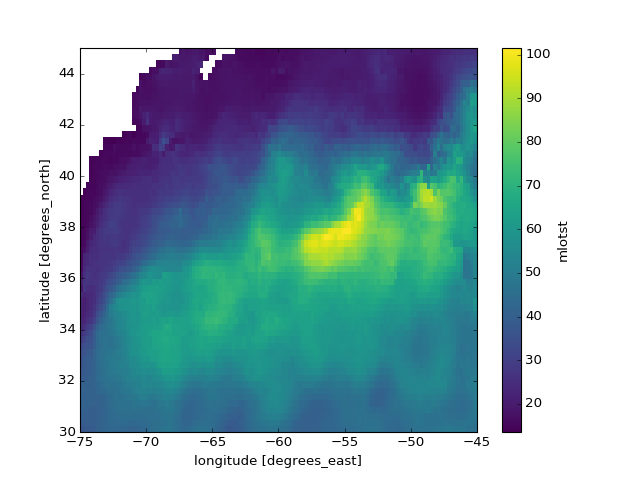

In [15]:
new1 = gulf.where(gulf.mlotst <= c2)

plt.close()
new1.mlotst.mean(dim='time').plot(robust=False)

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


<IPython.core.display.Javascript object>


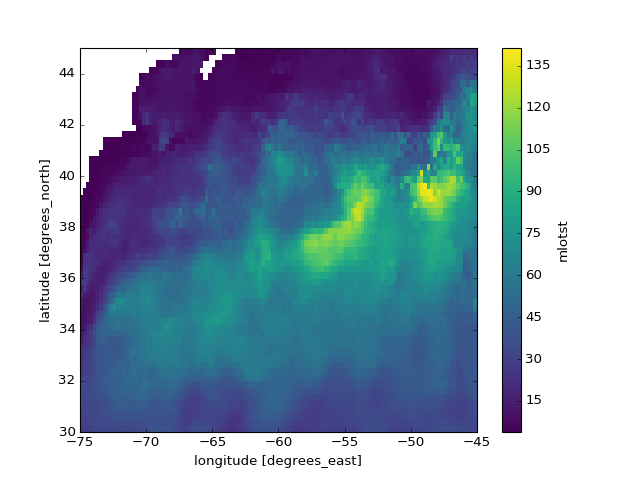

In [16]:
plt.close()
new1.mlotst.std(dim='time').plot(robust=False)


<IPython.core.display.Javascript object>


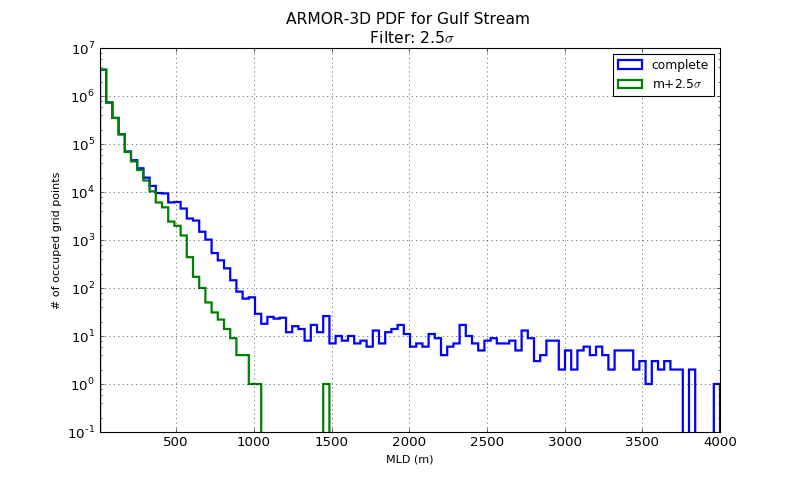

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [23]:

xlims_g = 10, 4000
ylims_g = 10e-2, 10e6


plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharey=True)

N_o, bins_o, patches_o = Histogram(gulf.mlotst, 100, xlims_g, ylims_g, 
                             None, ax, 1., 'step', 'complete', lw=2)

N, bins, patches = Histogram(new1.mlotst, 100, xlims_g, ylims_g, None, 
                             ax, 1., 'step', 'm+2.5$\sigma$', lw=2)
ax.set_title('ARMOR-3D PDF for Gulf Stream \n Filter: 2.5$\sigma$', fontsize=14)

plt.legend(fontsize=11)
#plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-PDF-comp.png')
plt.show()

In [84]:
p = N/N_o * 100.

print(p)

[99.9253887  99.25270055 99.41421256 99.06835601 97.17048506 94.54596876
 91.96245515 87.13432686 77.01844798 63.47689076 51.36003427 39.91430455
 31.93928629 27.47568523 15.66738044  6.73228346  6.7294751   4.90196078
  5.80524345  5.83554377  5.44747082  6.20689655  4.76190476  6.66666667
  1.5625      3.44827586  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  3.84615385  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.      

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [19]:
plt.close()

new1.mlotst.sel(time=slice('01-01-2')).where(new1.mask==1).groupby(
    'time.month').mean(dim='time').plot(col='month', col_wrap=3, robust=True)

StopIteration: 

<IPython.core.display.Javascript object>


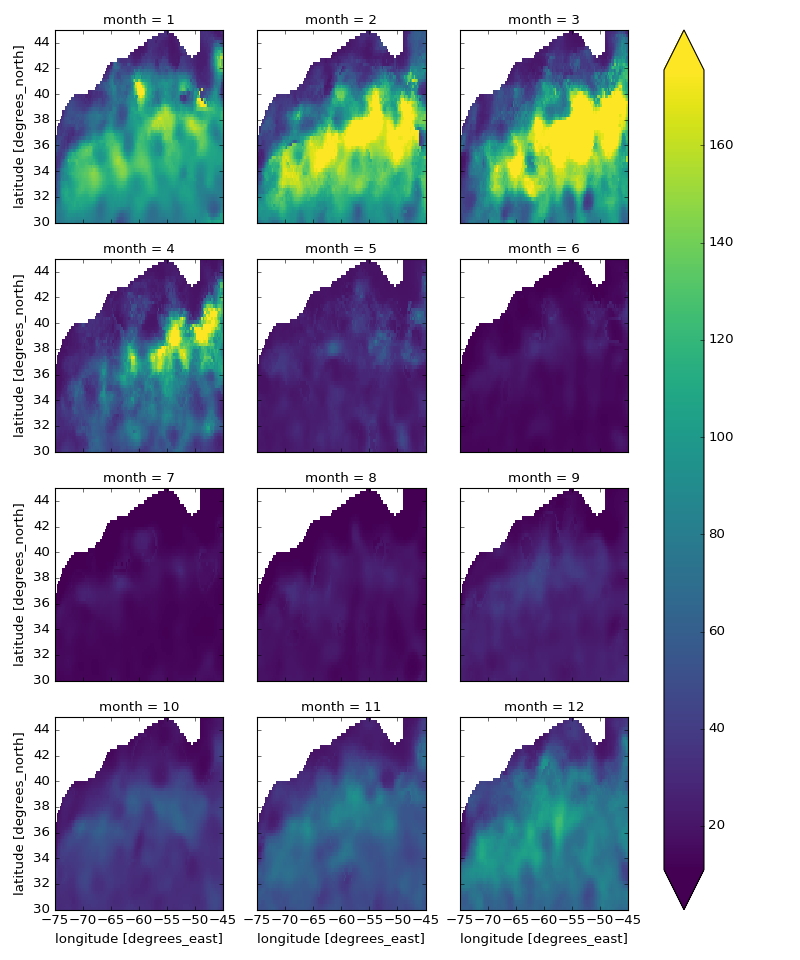

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [21]:
plt.close()

new1.mlotst.where(new1.mask==1).groupby(
    'time.month').mean(dim='time').plot(col='month', col_wrap=3, robust=True)

<IPython.core.display.Javascript object>


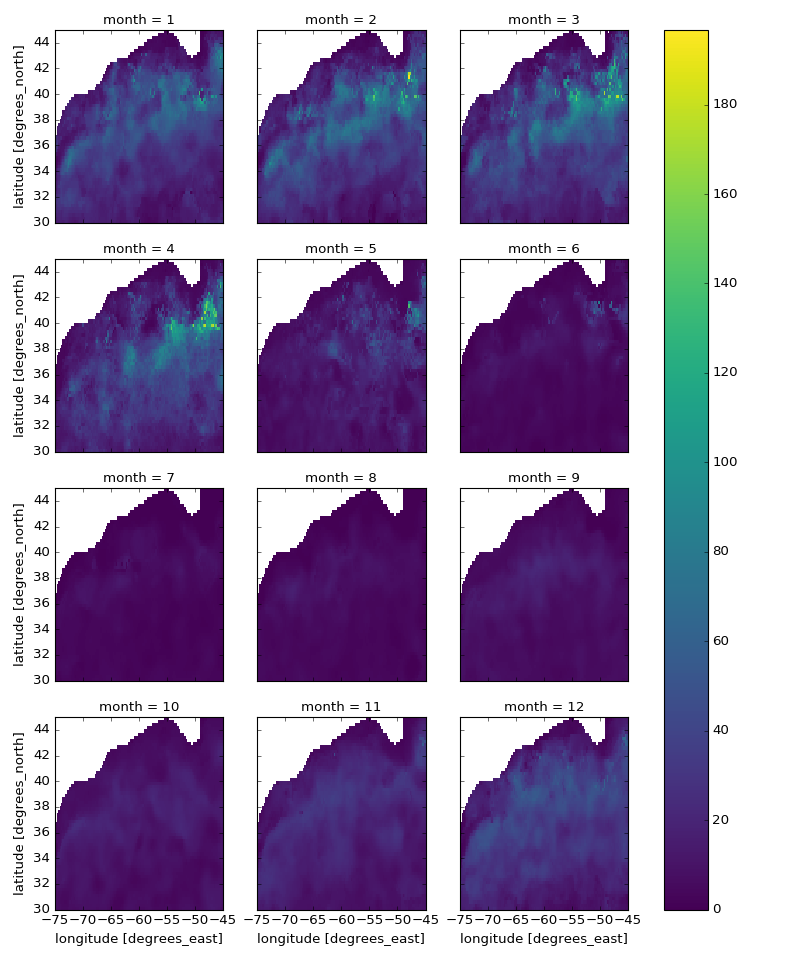

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [18]:
plt.close()
new1.mlotst.where(new.mask==1).groupby(
    'time.month').std(dim='time').plot(col='month', col_wrap=3, robust=False)

<IPython.core.display.Javascript object>


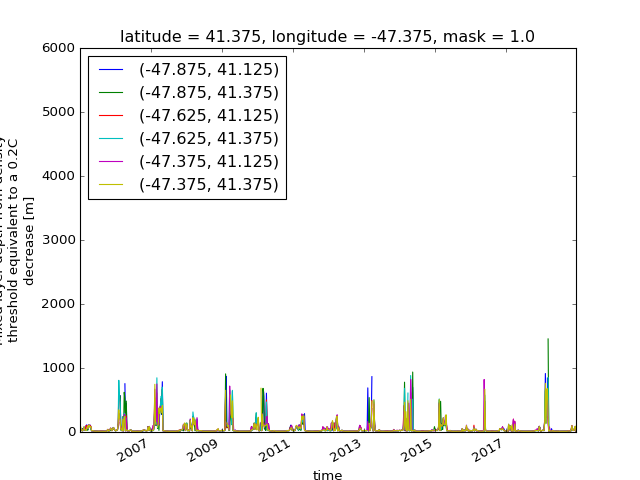

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [50]:
small = new1.mlotst.sel(longitude=slice(-48, -47.2), latitude=slice(41., 41.6))
small.latitude

plt.close()
for i in range(3):
    for j in range(2):
        lo = small.longitude[i].values.max()
        la = small.latitude[j].values.max()
        small.isel(longitude=i, latitude=j).plot(label=(lo,la))
        plt.legend(loc='upper left')
        plt.ylim(0, 6000)

### Using  MLD >=  mean +3. $\sigma$

Lets say that I want to get rid of the values that are MLD >= 2.5 $\sigma$

In [51]:
c3 = JFM_mn + 3. * JFM_st

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


<IPython.core.display.Javascript object>


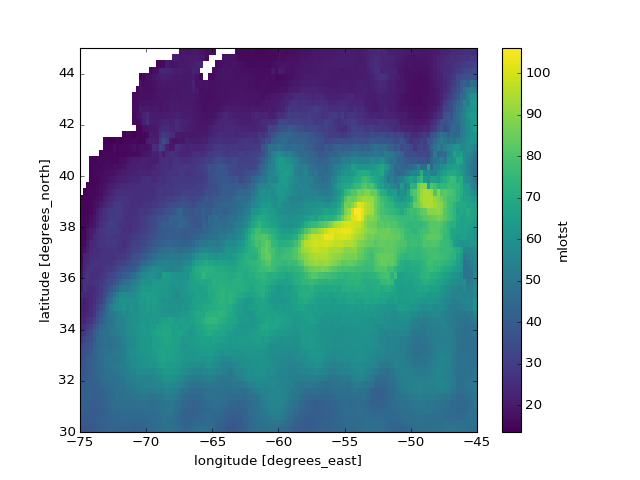

In [67]:
new3 = gulf.where(gulf.mlotst <= c3)

plt.close()
new3.mlotst.mean(dim='time').plot(robust=False)

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


<IPython.core.display.Javascript object>


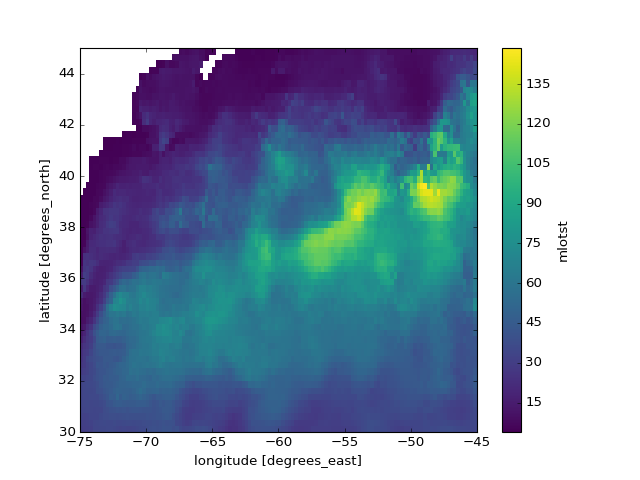

In [68]:
plt.close()
new3.mlotst.std(dim='time').plot(robust=False)


<IPython.core.display.Javascript object>


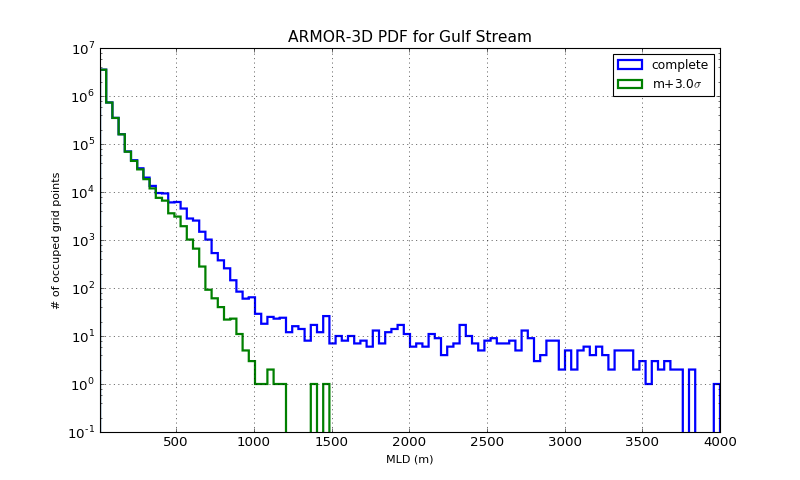

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [54]:

xlims_g = 10, 4000
ylims_g = 10e-2, 10e6


plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharey=True)

N_o, bins_o, patches_o  = Histogram(gulf.mlotst, 100, xlims_g, ylims_g, None, ax, 1., 'step', 
          'complete', lw=2)

N_3, bins_3, patches_3  = Histogram(new3.mlotst, 100, xlims_g, ylims_g, None, ax, 1., 'step', 
          'm+3.0$\sigma$', lw=2)
ax.set_title('ARMOR-3D PDF for Gulf Stream \n Filter: 3.0$\sigma$', fontsize=14)

plt.legend(fontsize=11)
#plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-PDF-comp.png')
plt.show()

<IPython.core.display.Javascript object>


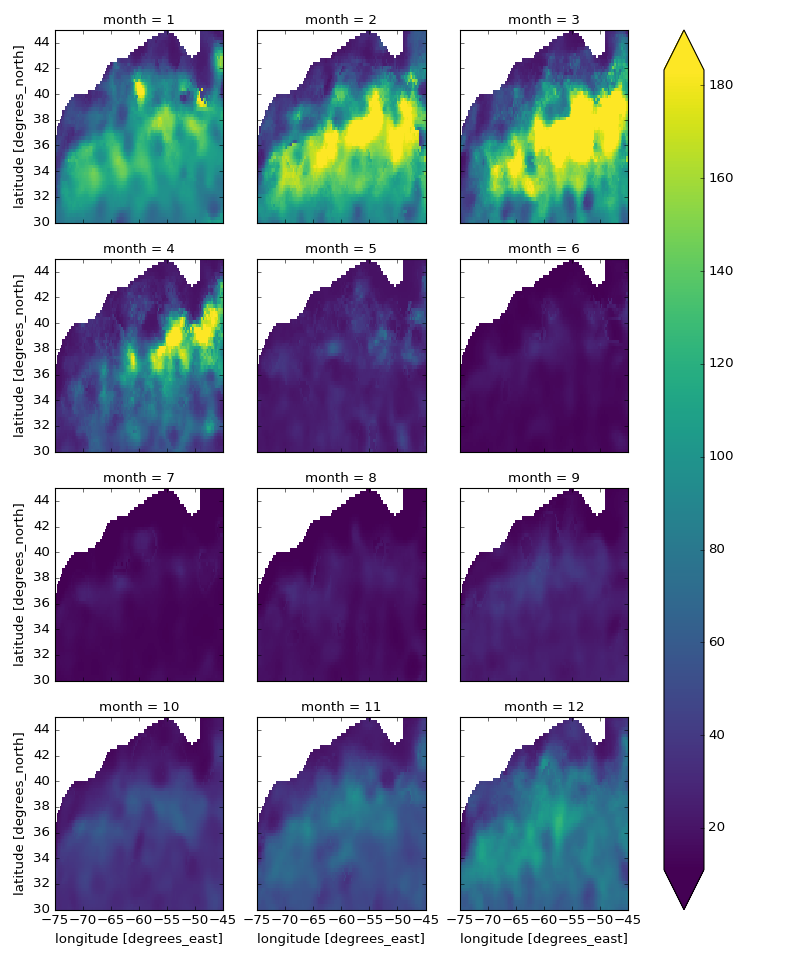

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [55]:
plt.close()

new3.mlotst.where(new.mask==1).groupby(
    'time.month').mean(dim='time').plot(col='month', col_wrap=3, robust=True)

<IPython.core.display.Javascript object>


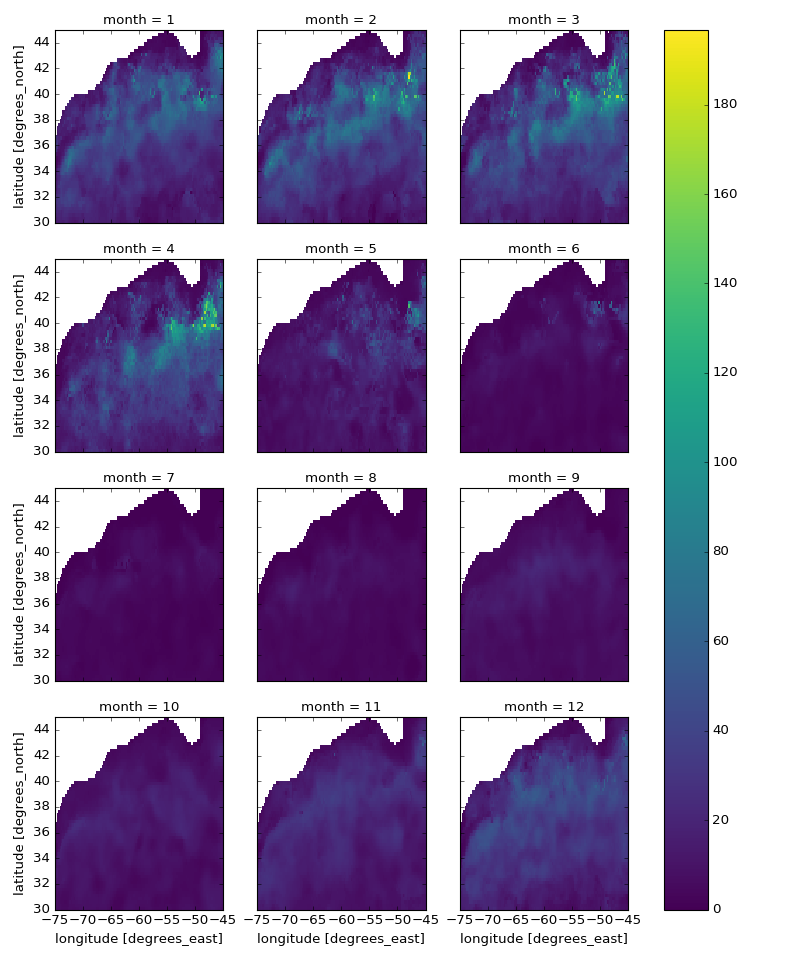

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [18]:
plt.close()
new3.mlotst.where(new.mask==1).groupby(
    'time.month').std(dim='time').plot(col='month', col_wrap=3, robust=False)

<IPython.core.display.Javascript object>


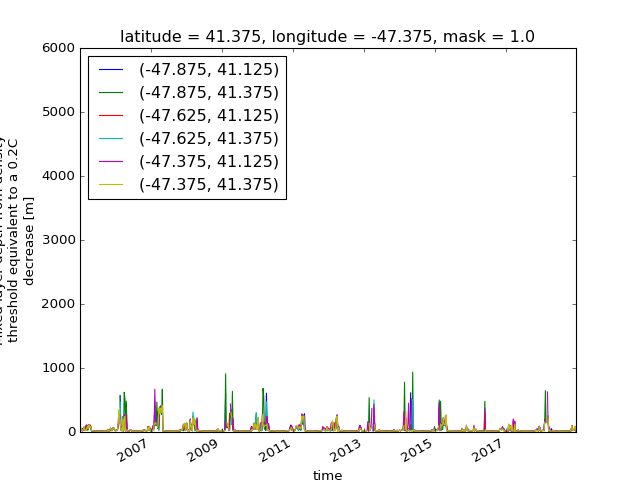

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [17]:
small = new3.mlotst.sel(longitude=slice(-48, -47.2), latitude=slice(41., 41.6))
small.latitude

plt.close()
for i in range(3):
    for j in range(2):
        lo = small.longitude[i].values.max()
        la = small.latitude[j].values.max()
        small.isel(longitude=i, latitude=j).plot(label=(lo,la))
        plt.legend(loc='upper left')
        plt.ylim(0, 6000)

## Using MLD >= 3.5 $\sigma$

Lets say that I want to get rid of the values that are MLD >= 3.5 $\sigma$

In [69]:
#c1 = JFM_mn + 1.5 * JFM_st
#c2 = JFM_mn + 2.5 * JFM_st
c35 = JFM_mn + 3.5 * JFM_st

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


<IPython.core.display.Javascript object>


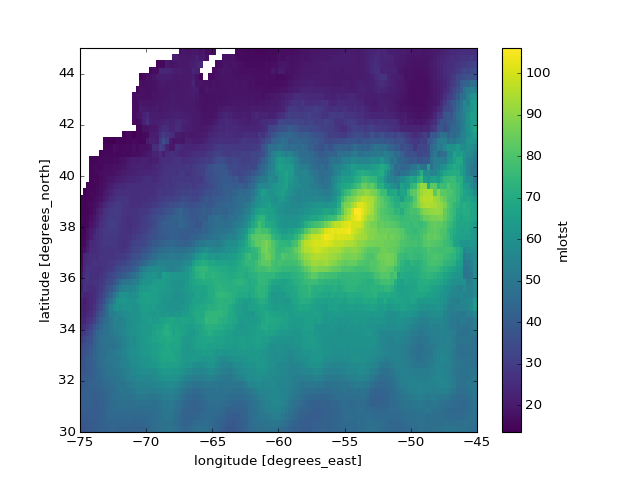

In [71]:
new35 = gulf.where(gulf.mlotst <= c35)

plt.close()
new35.mlotst.mean(dim='time').plot(robust=False)

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


<IPython.core.display.Javascript object>


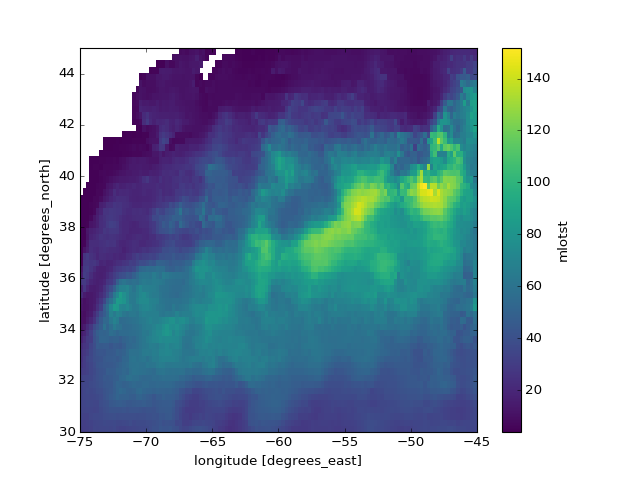

In [72]:
plt.close()
new35.mlotst.std(dim='time').plot(robust=False)


<IPython.core.display.Javascript object>


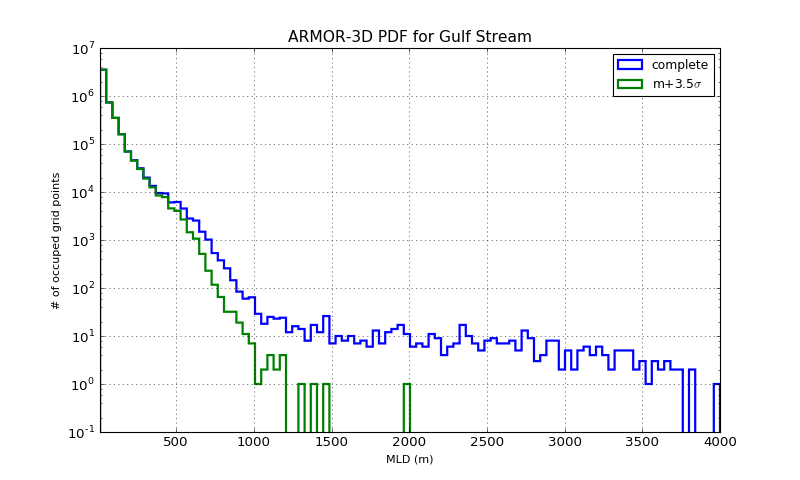

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [73]:

xlims_g = 10, 4000
ylims_g = 10e-2, 10e6


plt.close()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharey=True)

Histogram(gulf.mlotst, 100, xlims_g, ylims_g, None, ax, 1., 'step', 
          'complete', lw=2)

Histogram(new35.mlotst, 100, xlims_g, ylims_g, None, ax, 1., 'step', 
          'm+3.5$\sigma$', lw=2)
ax.set_title('ARMOR-3D PDF for Gulf Stream', fontsize=14)

plt.legend(fontsize=11)
#plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-PDF-comp.png')
plt.show()

In [ ]:
p_3 = N_3

In [1]:
plt.close()

new35.mlotst.where(new.mask==1).groupby(
    'time.month').mean(dim='time').plot(col='month', col_wrap=3, robust=True)

NameError: name 'plt' is not defined

<IPython.core.display.Javascript object>


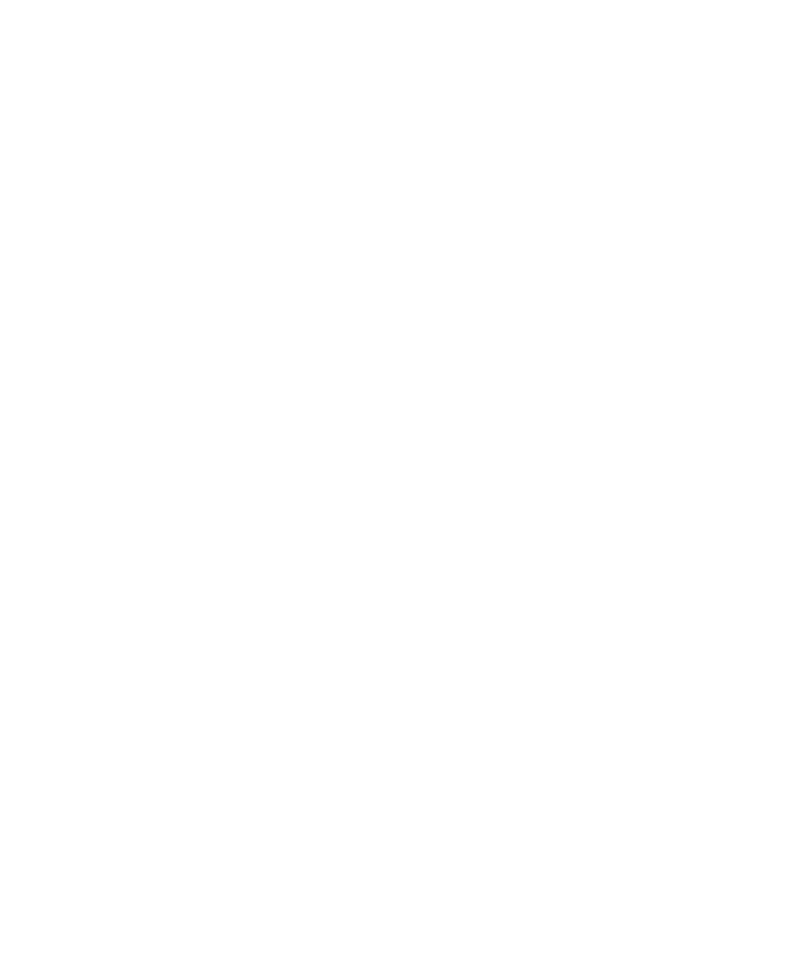

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [75]:
plt.close()
new35.mlotst.where(new.mask==1).groupby(
    'time.month').std(dim='time').plot(col='month', col_wrap=3, robust=False)

<IPython.core.display.Javascript object>


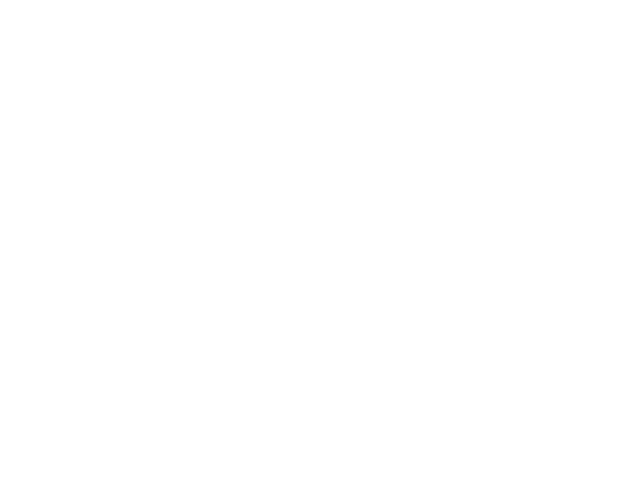

/usr/local/lib/python3.5/dist-packages/dask/array/reductions.py:384: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)


In [76]:
small = new35.mlotst.sel(longitude=slice(-48, -47.2), latitude=slice(41., 41.6))
small.latitude

plt.close()
for i in range(3):
    for j in range(2):
        lo = small.longitude[i].values.max()
        la = small.latitude[j].values.max()
        small.isel(longitude=i, latitude=j).plot(label=(lo,la))
        plt.legend(loc='upper left')
        plt.ylim(0, 6000)